In [33]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import Study, Trial
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna

from lib.wrapper import RoundingWrapper
from lib.scoring import cross_val_splits, kicktipp_scoring
from lib.simple_models import StaticEstimator
from lib.plots import cross_val_plot
import lib.theme as theme


DEBUG = False

In [2]:
df_matches = pd.read_pickle("data/matches_train.pickle")
splits = cross_val_splits(df_matches, start=5)

## Static Results

╒═════════╤═════════╤═════════╕
│ Model   │   Score │     Std │
╞═════════╪═════════╪═════════╡
│ 2:1     │ 362.125 │ 24.6751 │
├─────────┼─────────┼─────────┤
│ 1:0     │ 354.75  │ 27.896  │
├─────────┼─────────┼─────────┤
│ 1:1     │ 224     │ 15.748  │
├─────────┼─────────┼─────────┤
│ 0:0     │ 185     │ 13.4536 │
╘═════════╧═════════╧═════════╛


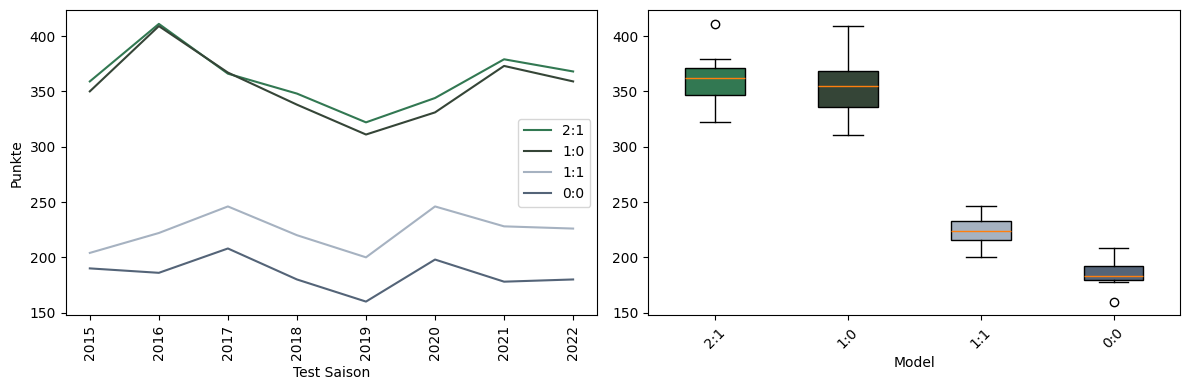

In [3]:
y_train = df_matches[["host_goals", "guest_goals"]].values

static_results = [
    [0, 0],
    [1, 1],
    [1, 0],
    [2, 1],
]

models = [StaticEstimator(result) for result in static_results]
labels = [f"{r[0]}:{r[1]}" for r in static_results]
scores = [
    cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring)
    for model in models
]

colors = [
    theme.GRAY_D,
    theme.GRAY,
    theme.GRASS_D,
    theme.GRASS,
]
cross_val_plot(df_matches, splits, labels, scores, color=colors)
!

In [4]:
X_train = df_matches.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_train = df_matches[["host_goals", "guest_goals"]].values
features = [
    "diff_last_season_goals",
    "diff_last_season_points",
    "diff_horizon_points",
    "diff_horizon_goals",
]
X_train = X_train[features]
X_train.tail()

,diff_last_season_goals,diff_last_season_points,diff_horizon_points,diff_horizon_goals
id,,,,
64166,-45.0,-25.0,-38.666667,-53.000000
64167,72.0,58.0,-27.500000,-31.500000
64168,-17.0,-13.0,-8.000000,-5.833333
64169,50.0,57.0,18.333333,8.000000
64170,6.0,9.0,14.333333,8.666667


## Random Forest

In [5]:
def objective(trial):
    rf_criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"]
    )
    rf_max_depth = trial.suggest_int("max_depth", 2, 15)
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 75)
    rf_min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    estimator = RoundingWrapper(
        RandomForestRegressor(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
            n_jobs=4,
        )
    )
    scores = cross_val_score(
        estimator, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring
    )
    return np.mean(scores)


rf_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True
)
rf_study.optimize(objective, n_trials=1 if DEBUG else 200)
result = {"score": rf_study.best_value, **rf_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))

[I 2024-09-16 22:49:27,391] A new study created in RDB with name: rf
[I 2024-09-16 22:49:28,075] Trial 0 finished with value: 366.875 and parameters: {'criterion': 'squared_error', 'max_depth': 9, 'n_estimators': 31, 'min_samples_split': 2}. Best is trial 0 with value: 366.875.
[I 2024-09-16 22:49:28,980] Trial 1 finished with value: 370.625 and parameters: {'criterion': 'squared_error', 'max_depth': 13, 'n_estimators': 63, 'min_samples_split': 49}. Best is trial 1 with value: 370.625.
[I 2024-09-16 22:49:29,582] Trial 2 finished with value: 364.875 and parameters: {'criterion': 'friedman_mse', 'max_depth': 8, 'n_estimators': 19, 'min_samples_split': 51}. Best is trial 1 with value: 370.625.
[I 2024-09-16 22:49:30,300] Trial 3 finished with value: 381.75 and parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 59, 'min_samples_split': 43}. Best is trial 3 with value: 381.75.
[I 2024-09-16 22:49:31,110] Trial 4 finished with value: 375.5 and parameters: {'criterion

╒═════════╤═══════════════╤═════════════╤════════════════╤═════════════════════╕
│   score │ criterion     │   max_depth │   n_estimators │   min_samples_split │
╞═════════╪═══════════════╪═════════════╪════════════════╪═════════════════════╡
│     391 │ squared_error │           4 │             62 │                  93 │
╘═════════╧═══════════════╧═════════════╧════════════════╧═════════════════════╛


In [6]:
def build_rf_model(study):
    best_params = study.best_params
    return RoundingWrapper(
        RandomForestRegressor(
            n_estimators=best_params["n_estimators"],
            criterion=best_params["criterion"],
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            n_jobs=4,
        )
    )

## Gradient Boosting

In [7]:
def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 25, 300)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda = trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha = trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingWrapper(
            XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                learning_rate=learning_rate,
                max_leaves=num_leaves,
                min_child_weight=min_child_weight,
                objective=trial.suggest_categorical(
                    "objective-xgb",
                    ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"],
                ),
            )
        )
    elif algo == "lgbm":
        estimator = RoundingWrapper(
            MultiOutputRegressor(
                LGBMRegressor(
                    verbose=-1,
                    n_jobs=-1,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    learning_rate=learning_rate,
                    num_leaves=num_leaves,
                    min_child_weight=min_child_weight,
                    objective=trial.suggest_categorical(
                        "objective-lgbm", ["rmse", "mae", "poisson", "mape"]
                    ),
                )
            )
        )

    scores = cross_val_score(
        estimator, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring
    )
    return np.mean(scores)


gb_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True
)
gb_study.optimize(objective, n_trials=1 if DEBUG else 400)
result = {"score": gb_study.best_value, **gb_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))

[I 2024-09-16 22:52:53,375] A new study created in RDB with name: gb
[I 2024-09-16 22:52:53,896] Trial 0 finished with value: 324.125 and parameters: {'algo': 'xgb', 'n_estimators': 264, 'max_depth': 7, 'lambda': 0.7211375708892875, 'alpha': 1.397979832681095, 'learning_rate': 0.4836566274861073, 'num_leaves': 4, 'min_child_weight': 8.196946849478143, 'objective-xgb': 'reg:squarederror'}. Best is trial 0 with value: 324.125.
[I 2024-09-16 22:52:54,327] Trial 1 finished with value: 318.875 and parameters: {'algo': 'lgbm', 'n_estimators': 147, 'max_depth': 11, 'lambda': 1.3112290064874754, 'alpha': 1.4277768081957583, 'learning_rate': 0.26789219818917404, 'num_leaves': 10, 'min_child_weight': 6.565491578552737, 'objective-lgbm': 'mae'}. Best is trial 0 with value: 324.125.
[I 2024-09-16 22:52:54,475] Trial 2 finished with value: 360.125 and parameters: {'algo': 'lgbm', 'n_estimators': 49, 'max_depth': 4, 'lambda': 0.8513237011940036, 'alpha': 1.0598228163422885, 'learning_rate': 0.351954

╒═════════╤════════╤════════════════╤═════════════╤══════════╤═════════╤═════════════════╤══════════════╤════════════════════╤══════════════════╕
│   score │ algo   │   n_estimators │   max_depth │   lambda │   alpha │   learning_rate │   num_leaves │   min_child_weight │ objective-lgbm   │
╞═════════╪════════╪════════════════╪═════════════╪══════════╪═════════╪═════════════════╪══════════════╪════════════════════╪══════════════════╡
│ 388.625 │ lgbm   │             38 │          14 │  1.79904 │ 1.38362 │       0.0923349 │            3 │            8.05024 │ poisson          │
╘═════════╧════════╧════════════════╧═════════════╧══════════╧═════════╧═════════════════╧══════════════╧════════════════════╧══════════════════╛


In [24]:
def build_gb_model(study, multi_output=True):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda = params["lambda"]
    reg_alpha = params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves = params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingWrapper(
            XGBRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                learning_rate=learning_rate,
                max_leaves=num_leaves,
                min_child_weight=min_child_weight,
                objective=params["objective-xgb"],
            )
        )
    elif algo == "lgbm":
        regressor = LGBMRegressor(
                    verbose=-1,
                    n_jobs=-1,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    learning_rate=learning_rate,
                    num_leaves=num_leaves,
                    min_child_weight=min_child_weight,
                    objective=params["objective-lgbm"],
                )
        if multi_output:
            regressor = MultiOutputRegressor(regressor)
        estimator = RoundingWrapper(regressor)
    return estimator

## KNN Regressor

In [9]:
def objective(trial: Trial):
    estimator = RoundingWrapper(
        KNeighborsRegressor(
            n_neighbors=trial.suggest_int("n_neighbors", 5, 100),
            weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
            metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"]),
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    scores = cross_val_score(pipeline, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)


knn_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="knn", load_if_exists=True
)
knn_study.optimize(objective, n_trials=1 if DEBUG else 300)
result = {"score": knn_study.best_value, **knn_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))


def build_knn_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(
        KNeighborsRegressor(
            n_neighbors=params["n_neighbors"], weights=params["weights"], metric=params["metric"]
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    return pipeline

[I 2024-09-16 22:54:21,017] A new study created in RDB with name: knn
[I 2024-09-16 22:54:21,119] Trial 0 finished with value: 370.875 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 370.875.
[I 2024-09-16 22:54:21,215] Trial 1 finished with value: 370.875 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 370.875.
[I 2024-09-16 22:54:21,286] Trial 2 finished with value: 326.125 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 370.875.
[I 2024-09-16 22:54:21,442] Trial 3 finished with value: 345.0 and parameters: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 0 with value: 370.875.
[I 2024-09-16 22:54:21,556] Trial 4 finished with value: 352.625 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 0 with value: 370.875.
[I 2024-09-16 22:

╒═════════╤═══════════════╤═══════════╤══════════╕
│   score │   n_neighbors │ weights   │ metric   │
╞═════════╪═══════════════╪═══════════╪══════════╡
│     383 │            93 │ uniform   │ l1       │
╘═════════╧═══════════════╧═══════════╧══════════╛


## MLP

In [10]:
def objective(trial: Trial):
    size_1 = trial.suggest_int("size_1", 4, 30)
    size_2 = trial.suggest_int("size_2", 4, 20)
    estimator = RoundingWrapper(
        MLPRegressor(
            hidden_layer_sizes=(size_1, size_2),
            learning_rate_init=trial.suggest_float("learning_rate_init", 0.0001, 0.01),
            max_iter=500,
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    scores = cross_val_score(pipeline, X_train, y_train, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)


mlp_study = optuna.create_study(
    direction="maximize", storage="sqlite:///db.sqlite3", study_name="mlp", load_if_exists=True
)
mlp_study.optimize(objective, n_trials=1 if DEBUG else 100)
result = {"score": mlp_study.best_value, **mlp_study.best_params}
print(tabulate([result], headers="keys", tablefmt="fancy_grid"))


def build_mlp_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(
        MLPRegressor(
            hidden_layer_sizes=(params["size_1"], params["size_2"]),
            learning_rate_init=params["learning_rate_init"],
        )
    )
    pipeline = make_pipeline(preprocessing.StandardScaler(), estimator)
    return pipeline

[I 2024-09-16 22:54:53,568] A new study created in RDB with name: mlp
[I 2024-09-16 22:54:55,337] Trial 0 finished with value: 369.75 and parameters: {'size_1': 19, 'size_2': 20, 'learning_rate_init': 0.005342316375031538}. Best is trial 0 with value: 369.75.
[I 2024-09-16 22:54:58,022] Trial 1 finished with value: 371.5 and parameters: {'size_1': 15, 'size_2': 9, 'learning_rate_init': 0.000856105968096308}. Best is trial 1 with value: 371.5.
[I 2024-09-16 22:54:59,297] Trial 2 finished with value: 376.75 and parameters: {'size_1': 21, 'size_2': 10, 'learning_rate_init': 0.006752910530701879}. Best is trial 2 with value: 376.75.
[I 2024-09-16 22:55:00,556] Trial 3 finished with value: 375.0 and parameters: {'size_1': 28, 'size_2': 11, 'learning_rate_init': 0.008023271875178319}. Best is trial 2 with value: 376.75.
[I 2024-09-16 22:55:02,250] Trial 4 finished with value: 373.0 and parameters: {'size_1': 6, 'size_2': 10, 'learning_rate_init': 0.003965424097104739}. Best is trial 2 with v

╒═════════╤══════════╤══════════╤══════════════════════╕
│   score │   size_1 │   size_2 │   learning_rate_init │
╞═════════╪══════════╪══════════╪══════════════════════╡
│ 387.375 │       10 │       13 │           0.00256569 │
╘═════════╧══════════╧══════════╧══════════════════════╛


╒═════════╤═════════╤═════════╕
│ Model   │   Score │     Std │
╞═════════╪═════════╪═════════╡
│ GB      │ 388.625 │ 13.4994 │
├─────────┼─────────┼─────────┤
│ RF      │ 388.5   │ 15.1658 │
├─────────┼─────────┼─────────┤
│ KNN     │ 383     │ 17.5997 │
├─────────┼─────────┼─────────┤
│ MLP     │ 373.625 │ 15.8346 │
├─────────┼─────────┼─────────┤
│ 2:1     │ 362.125 │ 24.6751 │
╘═════════╧═════════╧═════════╛


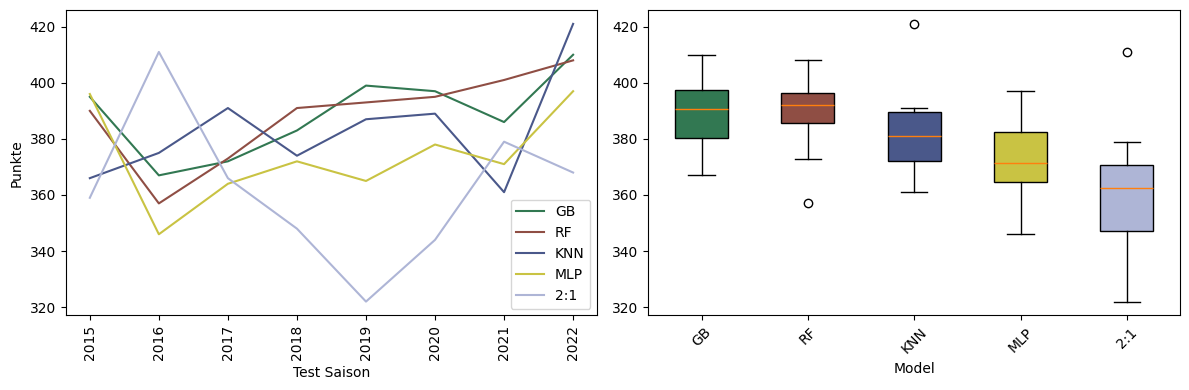

In [11]:
models = {
    "2:1": StaticEstimator([2, 1]),
    "RF": build_rf_model(rf_study),
    "GB": build_gb_model(gb_study),
    "KNN": build_knn_model(knn_study),
    "MLP": build_mlp_model(mlp_study),
}
color = [theme.BLUE_GRAY, theme.BROWNISH, theme.GRASS, theme.WHALE, theme.GOLD]

labels = list(models.keys())
scores = [
    cross_val_score(models[name], X_train, y_train, cv=splits, scoring=kicktipp_scoring)
    for name in models.keys()
]

fig, axs = cross_val_plot(df_matches, splits, labels, scores, color=color)

## Make test predictions

In [34]:
final_model = build_gb_model(gb_study)
final_model.fit(X_train, y_train)

df_matches_test = pd.read_pickle("data/matches_test.pickle")
X_test = df_matches_test[features]

y_pred = final_model.predict(X_test)
y_pred_raw = final_model.regressor.predict(X_test)

df_test_predictions = df_matches_test.copy()
df_test_predictions["host_goals_pred"] = y_pred[:, 0].astype(int)
df_test_predictions["guest_goals_pred"] = y_pred[:, 1].astype(int)
df_test_predictions["host_goals_pred_raw"] = y_pred_raw[:, 0]
df_test_predictions["guest_goals_pred_raw"] = y_pred_raw[:, 1]
df_test_predictions = df_test_predictions[
    [
        "season",
        "match_day",
        "host_name",
        "guest_name",
        "host_goals",
        "guest_goals",
        "host_goals_pred",
        "guest_goals_pred",
    ]
]
df_test_predictions.to_pickle("data/test_predictions.pickle")

In [36]:
df_matches_all = pd.read_pickle("data/matches_train_all.pickle")
X_train_all = df_matches_all[features]
y_train_all = df_matches_all[["host_goals", "guest_goals"]].values

final_model.fit(X_train_all, y_train_all)

df_matches_test = pd.read_pickle("data/matches_future.pickle")
X_test = df_matches_test[features]

y_pred = final_model.predict(X_test)
y_pred_raw = final_model.regressor.predict(X_test)

df_test_predictions = df_matches_test.copy()
df_test_predictions["host_goals_pred"] = y_pred[:, 0].astype(int)
df_test_predictions["guest_goals_pred"] = y_pred[:, 1].astype(int)
df_test_predictions["host_goals_pred_raw"] = y_pred_raw[:, 0]
df_test_predictions["guest_goals_pred_raw"] = y_pred_raw[:, 1]
df_test_predictions = df_test_predictions[
    [
        "season",
        "match_day",
        "host_id",
        "host_name",
        "guest_name",
        "guest_id",
        "host_goals",
        "guest_goals",
        "host_goals_pred",
        "guest_goals_pred",
    ]
]
df_test_predictions.to_pickle("data/future_predictions.pickle")